In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

import pickle

#Import the transactions data

In [ ]:
df_transactions = pd.read_csv('transactions.csv')
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_transactions.set_index('date')

,amount,account_id
date,,
2019-12-16,-29.09,1
2019-12-16,160.00,1
2019-12-16,-14.00,1
2019-12-17,-94.50,1
2019-12-17,50.00,1
...,...,...
2020-09-22,-2.40,440
2020-09-22,106.73,440
2020-09-22,2168.50,440


In [ ]:
# Drop the duplicates data and group account by date
new_df = df_transactions.drop_duplicates()
new_df = df_transactions.groupby(['account_id', 'date']).sum()
new_df = new_df.rename(columns={'amount':'outgoing'})
new_df

outgoing
account_id date                
0          2020-06-03    120.00
           2020-07-03    120.00
           2020-07-18   2710.38
1          2019-12-16    116.91
           2019-12-17    331.79
...                         ...
440        2020-09-17   2200.00
           2020-09-18  -1213.46
           2020-09-21    -18.00
           2020-09-22   2166.10
           2020-09-24   -257.00

[62299 rows x 1 columns]

#Accounts have more than 180 days of history

In [ ]:
def accounts_180days():
  df_transactions = pd.read_csv('transactions.csv')
  df_transactions['date'] = pd.to_datetime(df_transactions['date'])
  df_transactions.set_index('date')

  # Drop the duplicates data and group account by date
  new_df = df_transactions.drop_duplicates()
  new_df = df_transactions.groupby(['account_id', 'date']).sum()
  new_df = new_df.rename(columns={'amount':'outgoing'})
  
  # Check which accounts have more than 180 days of history
  df_account_180days = new_df.groupby(level='account_id').size() #group account_id by the date
  df_account_180days = pd.DataFrame(data=df_account_180days)
  df_account_180days = df_account_180days.rename(columns={0: 'num_date_transactions'})
  df_account_180days = df_account_180days.loc[df_account_180days.num_date_transactions>180]

  return df_account_180days

df_account_180days = accounts_180days()
df_account_180days

,num_date_transactions
account_id,
1,182
2,258
7,337
12,312
14,182
...,...
432,277
434,321
435,208


In [ ]:
# Summarize the amount monthly for each account (outgoing monthly for each account)
new_df = new_df.groupby(['account_id']+[pd.Grouper(freq='M', level='date')]).sum()
# New dataframe with the accounts which have more than 180 days of history
new_df = new_df.loc[df_account_180days.index.values]
# Sort the dataframe by date
new_df = new_df.reset_index(level=0).sort_index()
# Save the Time series
pickle.dump(new_df, open('ts_outgoing.pickle', 'wb'))
new_df

,account_id,outgoing
date,,
2018-01-31,109,155.44
2018-01-31,321,2000.00
2018-01-31,213,500.88
2018-01-31,110,-161.17
2018-01-31,134,2.47
...,...,...
2020-09-30,218,-76.72
2020-09-30,221,125.47
2020-09-30,79,1894.58


In [ ]:
# Function to get a time sieres by giving an account's id
def get_ts_account(id):
  ts = new_df.loc[new_df['account_id']==id]
  ts = ts.drop(['account_id'], axis=1)
  return ts
ts = get_ts_account(439) #for example, we got the outgoing data of the account_id=439 here
ts

,outgoing
date,
2018-03-31,1106.80
2018-04-30,-1049.39
2018-05-31,-56.15
2019-10-31,58.90
2019-11-30,116.92
2019-12-31,120.24
2020-01-31,15.57
2020-02-29,79.76
2020-03-31,-15.18


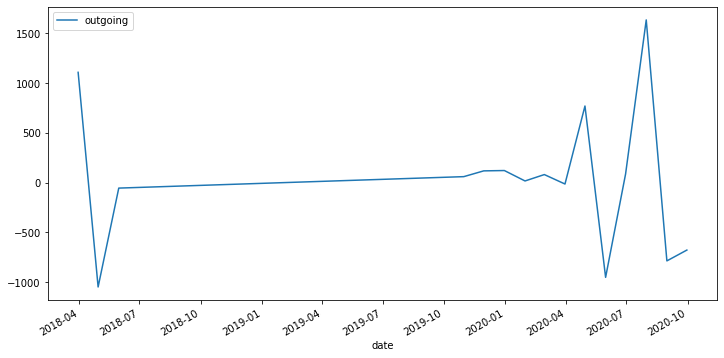

In [ ]:
# Plot the time series
ts.plot(figsize=(12,6))
plt.show()

# ARIMA model

We're going to build a ARIMA model for a time series of an account(here account_id=439), and then we weill build a ARIMA model for each account_id.

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models. That's why I chose the ARIMA for our time series.

An ARIMA model is characterized by 3 terms: p, d, q where,

- p is the order of the AR term

- q is the order of the MA term

- d is the number of differencing required to make the time series stationary

In [ ]:
# Split into train and test sets
train_size = int(ts.shape[0] * 0.8)
train, test = ts.iloc[0:train_size], ts.iloc[train_size:ts.shape[0]]
print(train.shape, test.shape)

(12, 1) (3, 1)


## ADF test for Stationarity (determining  D)

The most common and convenient method to stationarize the series is by differencing the series at least once until it becomes approximately stationary.

In [ ]:
# The Augmented Dickey Fuller Test test for stationarity 
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print(f'Inference: The time series is {"non-" if result[1]>=0.05 else ""}stationary' )

ADF Statistic: -3.304839
p-value: 0.014664
Inference: The time series is stationary


Here we already got a stationary time series, so we can assume D=0. Ortherwise, we have check if the first order differenced series is stationary or not. We have to find the D value until we get a stationary order diferenced series.

In [ ]:
# Check first order differenced series (if the series is not stationary)
#result = adfuller(train.diff().dropna())
#print('ADF Statistic: %f' % result[0])
#print('p-value: %f' % result[1])
#print(f'Inference: The time series is {"non-" if result[1]>=0.05 else ""}stationary' )

## Determining P and Q
We assume here our P=6, because we have to predict next month outgoing given the past 6 months of transactions, we're going to determine Q by looking at the AutoCorrelation Function.

We can look at the ACF plot for the number of MA terms(Q value). An MA term is technically, the error of the lagged forecast.

The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

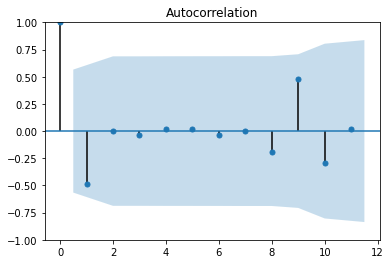

In [ ]:
plot_acf(train);

So we get p=6, d=0, q=1. We will set q=1 for the rest of account for the facilitate the process.

In [ ]:
# Train the ARIMA model 
order = (6,0,1)
model = ARIMA(endog=train, order=(6,0,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:               outgoing   No. Observations:                   12
Model:                 ARIMA(6, 0, 1)   Log Likelihood                -188.238
Date:                Sun, 31 Oct 2021   AIC                            394.476
Time:                        13:43:05   BIC                            398.840
Sample:                             0   HQIC                           392.861
                                 - 12                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.6522      0.003   8433.834      0.000      27.646      27.659
ar.L1          0.2228      0.018     12.149      0.000       0.187       0.259
ar.L2          0.8313      0.015     55.562      0.0

The model summary reveals a lot of information. The table in the middle is the coefficients table where the values under ‘coef’ are the weights of the respective terms.

In [ ]:
# Get prediction for test time series
predictions = pd.Series(model_fit.forecast(test.shape[0]+1))
print(predictions)

12    -51.971726
13    721.833791
14   -497.156243
15   -414.440059
Name: predicted_mean, dtype: float64


In [ ]:
# Evaluation Metric 
actuals = test['outgoing']
print("\n MAPE: \n", mean_absolute_percentage_error(predictions[0:len(predictions)-1], actuals))


 MAPE: 
 11.627441005691578


## Plot Actual vs Predicted 

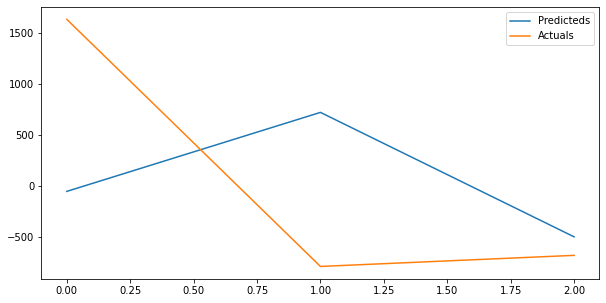

In [ ]:
# Plot the predicted and actual values
plt.figure(figsize=(10,5))
plt.plot(predictions.values[0:len(predictions.values)-1], label='Predicteds')
plt.plot(actuals.values, label='Actuals')
plt.legend(loc='best')

In [ ]:
# Prediction of next month outgoing
print("Prediction of next month outgoing:", predictions.iloc[-1])

Prediction of next month outgoing: -414.44005893821407


# Function of prediction function that takes an account, a list of transactions recorded on the account, and ouputs a prediction for the aggregated next month outgoing for that account

In [ ]:
# Prediction function that takes an account, a list of transactions recorded on the account, and ouputs a prediction for the aggregated next month outgoing for that account.
def ARIMA_predict(id, ts):
  p, d, q = 6, 0, 1 #here we set the p=6 because we want to predict next month outgoing given the past 6 months of transactions
  train_size = int(ts.shape[0]*0.8)
  train, test = ts.iloc[0:train_size], ts.iloc[train_size:ts.shape[0]]
  print("Train's shpae:", train.shape, "Test's shape:", test.shape)

  # Setting of d
  result = adfuller(train)
  if result[1]<0.05:
    d=0
    print("\n This time series is stationary.")
  else:
    while result[1]>=0.05:
      d = d+1
      train = train.diff()
      result = adfuller(train.dropna())
      if result[1]<0.05:
        print("This order", d, "differenced series is stationary.")
  
  # Train the ARIMA model 
  order = (p, d, q)
  model = ARIMA(endog=train, order=order, enforce_stationarity=False)
  model_fit = model.fit()

  # Save the model
  model_fit.save(f'arima_{id}.pkl')

  loaded = ARIMAResults.load(f'arima_{id}.pkl')
  print("\n",loaded.summary())
  predictions = pd.DataFrame(loaded.forecast(test.shape[0]+1))
  print("Prediction of the next month outgoing of this account:\n")

  return predictions[-1:]

In [ ]:
# Save the models and the times series of the accounts (1 model and 1 time series per account)
for i in (df_account_180days.index):
  ts = get_ts_account(i)
  pickle.dump(ts, open(f'ts_account_{i}.pickle', 'wb'))
  ARIMA_predict(i, ts)